In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from HiggsML.systematics import systematics
hep.style.use(hep.style.ATLAS)

path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'

import os
os.chdir(f"{path_prefix}")

from HiggsML.datasets import download_dataset

In [2]:
data = download_dataset("https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip")

2025-06-04 20:41:11,808 - HiggsML.datasets     - INFO     - Handling as URL: https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip
2025-06-04 20:41:11,809 - HiggsML.datasets     - INFO     - Current working directory: /data/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau
2025-06-04 20:41:11,816 - HiggsML.datasets     - INFO     - Total rows: 220099101
2025-06-04 20:41:11,817 - HiggsML.datasets     - INFO     - Test size: 66029730


In [3]:
# Assign an integer with each of the processes (same as the dictionary used to load)
labels_dict = {"htautau": 0,
              "ztautau":1,
              "ttbar":2}

# exclude low stats diboson sample for now
# labels_dict = {"htautau": 0,
#               "ztautau":1,
#               "ttbar":2,
#               "diboson":3}


# np.save(f"{saved_data}labels_dictionary.npy", labels_dict)


In [4]:
list_of_processes = list(labels_dict.keys())

In [5]:
data.load_train_set(train_size=0.05)
df_training = data.get_train_set()

2025-06-04 20:41:18,389 - HiggsML.datasets     - INFO     - Selected train size: 7703468
2025-06-04 20:41:47,364 - HiggsML.datasets     - INFO     - Data loaded successfully


In [6]:
df_training['type'] = df_training['detailed_labels'].copy()

In [7]:
mask_selected_processes = np.isin(df_training.detailed_labels.to_numpy(), list_of_processes)
df_training = df_training[mask_selected_processes].copy()

In [8]:
df_training.detailed_labels.unique()

array(['ztautau', 'htautau', 'ttbar'], dtype=object)

In [9]:
df_training['train_labels'] = -1 

for key in labels_dict:
    df_training.loc[df_training['detailed_labels'] == key, 'train_labels'] = labels_dict[key]


In [10]:
df_training.columns.unique()

Index(['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_n_jets',
       'PRI_jet_all_pt', 'PRI_met', 'PRI_met_phi', 'weights',
       'detailed_labels', 'labels', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'type', 'train_labels'],
      dtype='object')

In [11]:
mask_selection = (df_training['PRI_lep_pt']<=200.0) & (df_training['PRI_met']<=250.0) & (df_training['PRI_had_pt']<=250.0) & (df_training['PRI_jet_all_pt']<=500.0)
df_training = df_training[mask_selection].copy()


In [12]:
syst_settings = {
    'TES_up': {'tes': 1.02},
    'TES_dn': {'tes': 0.98},
    'JES_up': {'jes': 1.02},
    'JES_dn': {'jes': 0.98}
}

dataset_dict = {}

dataset_dict['nominal'] = systematics(
        data_set = df_training,
        dopostprocess=True
        )

for sample_name, syst_args in syst_settings.items():
    dataset_dict[sample_name] = systematics(
        data_set = df_training, 
        dopostprocess=True, 
        **syst_args
    )



In [13]:
input_features = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt', 'PRI_jet_leading_eta', 'PRI_n_jets']
columns_to_keep = input_features + ['weights', 'detailed_labels', 'type', 'train_labels']

for sample in dataset_dict:
    dataset_dict[sample] = dataset_dict[sample][columns_to_keep].copy()

In [14]:
path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'

# Path for saving interemdiate objects, like NN predictions
saved_data = f'{path_prefix}cached_data/'


if not os.path.exists(saved_data):
    print(f"Making new directory for caching data {saved_data}")
    os.makedirs(saved_data)


In [15]:
for sample in dataset_dict: 
    dataset_dict[sample].to_hdf(f"{saved_data}df_{sample}.h5", key="dataset", mode="w")

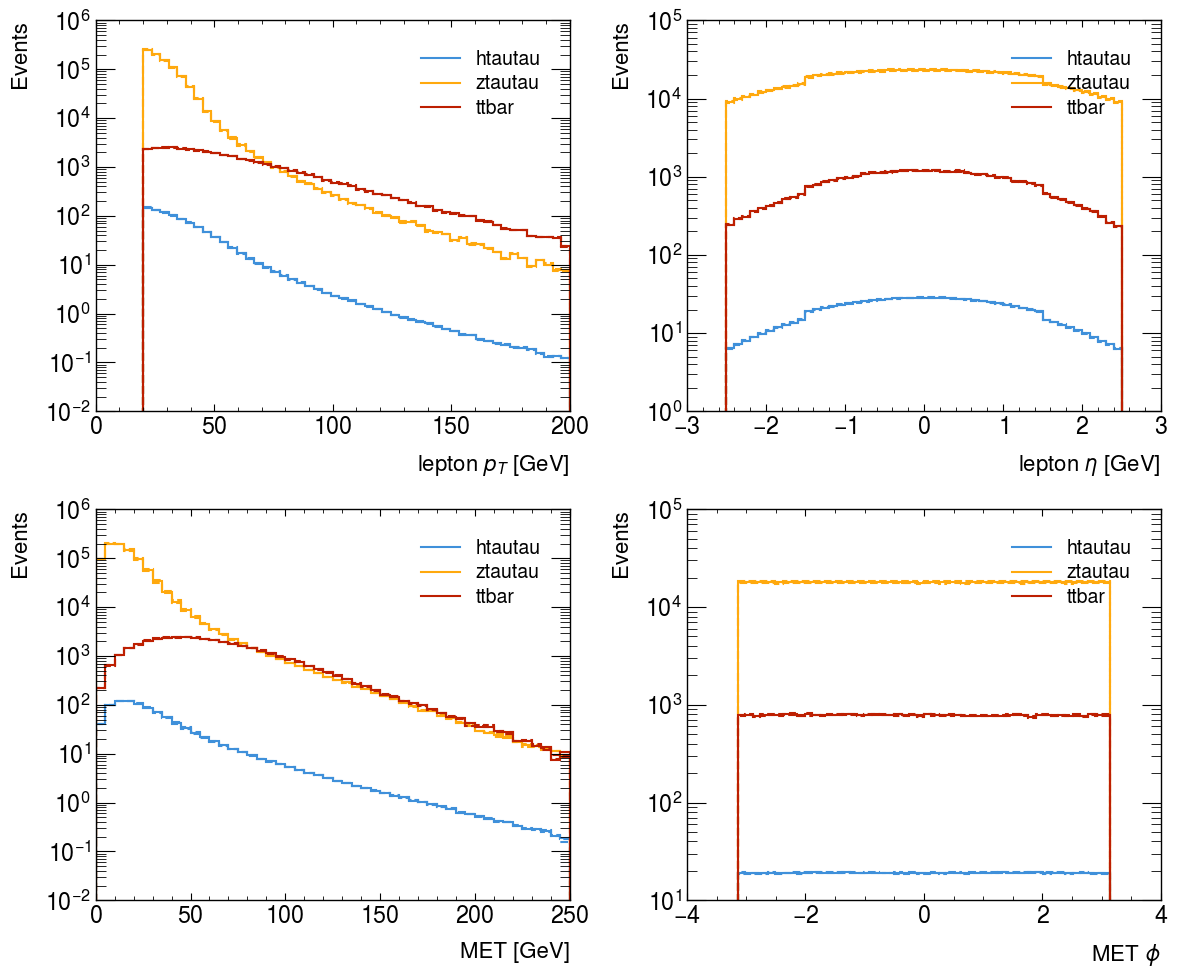

In [16]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']
hist = {feature: {label: {} for label in labels_dict} for feature in columns}
bins_dict = {}

for feature in columns:

    feature_array_nominal = dataset_dict['nominal'][feature].to_numpy()
    bins = np.histogram_bin_edges(feature_array_nominal, bins=nbins)
    bins_dict[feature] = bins

    for variation in variations_to_plot:
        df = dataset_dict[variation]
        for label in labels_dict:
            mask = (df.detailed_labels == label)
            vals = df[mask][feature].to_numpy()
            wts  = df[mask]['weights'].to_numpy()
            hist_vals, _ = np.histogram(vals, weights=wts, bins=bins)
            hist[feature][label][variation] = hist_vals

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_label_map = {label: palette[i % len(palette)] for i, label in enumerate(labels_dict)}

linestyle_map = {
    'nominal': '-',
    'TES_up': '--',
    'TES_dn': '--'
}

for ax, feature in zip(axes, columns):
    for label in labels_dict:
        for variation in variations_to_plot:
            hep.histplot(
                hist[feature][label][variation],
                bins=bins_dict[feature],
                label=(label if variation == 'nominal' else None),
                ax=ax,
                linewidth=1.5,
                color=color_label_map[label],
                linestyle=linestyle_map[variation]
            )
    ax.set_yscale('log')
    ax.set_xlabel(xlabel_dict[feature], size=16)
    ax.set_ylabel('Events', size=16)
    ax.legend()

plt.tight_layout()
plt.show()


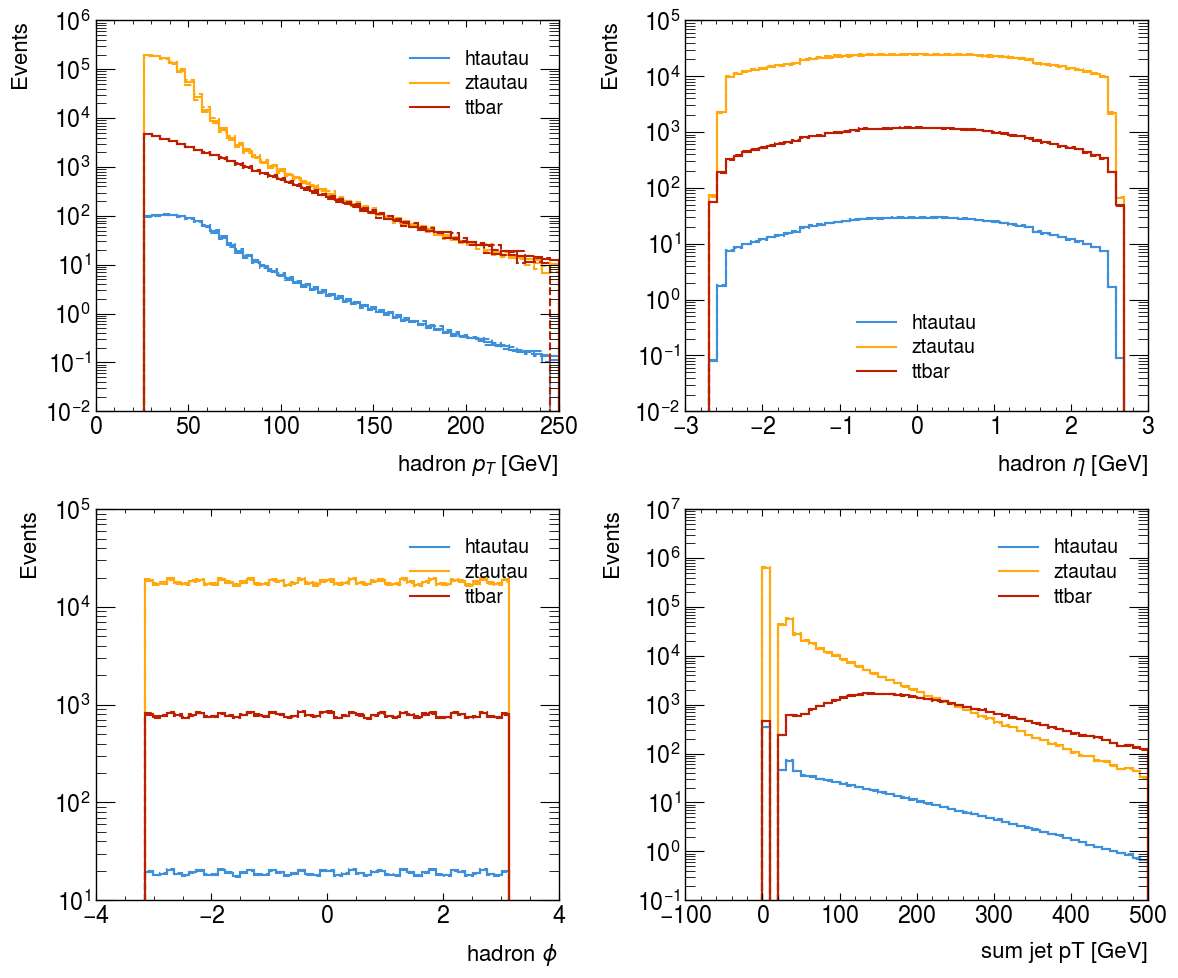

In [17]:
columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt']
# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_had_pt': 'hadron $p_T$ [GeV]', 
    'PRI_had_eta': 'hadron $\eta$ [GeV]', 
    'PRI_had_phi': 'hadron $\phi$', 
    'PRI_jet_all_pt': 'sum jet pT [GeV]',
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']
hist = {feature: {label: {} for label in labels_dict} for feature in columns}
bins_dict = {}

for feature in columns:

    feature_array_nominal = dataset_dict['nominal'][feature].to_numpy()
    bins = np.histogram_bin_edges(feature_array_nominal, bins=nbins)
    bins_dict[feature] = bins

    for variation in variations_to_plot:
        df = dataset_dict[variation]
        for label in labels_dict:
            mask = (df.detailed_labels == label)
            vals = df[mask][feature].to_numpy()
            wts  = df[mask]['weights'].to_numpy()
            hist_vals, _ = np.histogram(vals, weights=wts, bins=bins)
            hist[feature][label][variation] = hist_vals

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_label_map = {label: palette[i % len(palette)] for i, label in enumerate(labels_dict)}

linestyle_map = {
    'nominal': '-',
    'TES_up': '--',
    'TES_dn': '--'
}

for ax, feature in zip(axes, columns):
    for label in labels_dict:
        for variation in variations_to_plot:
            hep.histplot(
                hist[feature][label][variation],
                bins=bins_dict[feature],
                label=(label if variation == 'nominal' else None),
                ax=ax,
                linewidth=1.5,
                color=color_label_map[label],
                linestyle=linestyle_map[variation]
            )
    ax.set_yscale('log')
    ax.set_xlabel(xlabel_dict[feature], size=16)
    ax.set_ylabel('Events', size=16)
    ax.legend()

plt.tight_layout()
plt.show()

